In [1]:
from scipy import sparse, stats
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import sys
import scipy.io
import csv
import gzip
import os

In [2]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

In [3]:
cb_file='./example/NA12878.qc'
cb_stat = pd.read_csv(cb_file,header=0)
cb_keep = cb_stat.loc[cb_stat['keep']==1,'cb']

Text(0.5, 0, '# UMI')

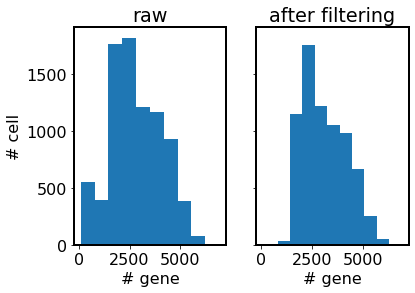

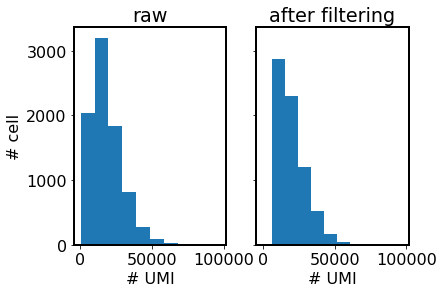

In [4]:
fig,ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].set_ylabel('# cell')
ax[0].hist(cb_stat['num_gene'])
ax[0].set_title('raw')
ax[0].set_xlabel('# gene')
ax[1].hist(cb_stat.loc[cb_stat['keep']==1,'num_gene'])
ax[1].set_title('after filtering')
ax[1].set_xlabel('# gene')

fig,ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].set_ylabel('# cell')
ax[0].hist(cb_stat['num_umi'])
ax[0].set_title('raw')
ax[0].set_xlabel('# UMI')
ax[1].hist(cb_stat.loc[cb_stat['keep']==1,'num_umi'])
ax[1].set_title('after filtering')
ax[1].set_xlabel('# UMI')

In [14]:
import warnings
warnings.filterwarnings('ignore')
from lib.ase_bn import *
umi_file='./example/test.mtx'
ase_file='./example/test.ase'

umi_raw = pd.read_csv(umi_file)
ase_raw = pd.read_csv(ase_file)

# filtered cells
cb_keep = cb_stat.loc[cb_stat['keep']==1]
umi = pd.merge(umi_raw, cb_keep, on='cb')
ase = pd.merge(ase_raw, cb_keep, on='cb')

ase_infer_outfile = './example/test.ase'
allele_infer(umi,ase,ase_infer_outfile,min_reads=1)

display(pd.merge(umi,ase, on=['cb','gene'])[['cb','gene','ub_H1','ub_H2', 'umi']].head(5))

,cb,gene,ub_H1,ub_H2,umi
0,ACAGCTACATGGTTGT-1,ENSG00000196735,1,0,3
1,CAGCCGATCCAGATCA-1,ENSG00000196735,1,0,5
2,CCGTTCATCTCCTATA-1,ENSG00000196735,1,0,1
3,CTCGGGAAGGGTTTCT-1,ENSG00000196735,2,0,11
4,TTGCCGTTCAGCGACC-1,ENSG00000196735,1,0,8


In [15]:
ase_infer = pd.read_csv(ase_infer_outfile+'.infer',header=0)
ase_stat  = pd.read_csv(ase_infer_outfile+'.record',header=0)

display(ase_stat.head(5))
display(ase_infer.head(5))

,gene,nref,nall,percent,a_hat,Ia_lb,Ia_ub,b_hat,Ib_lb,Ib_ub
0,ENSG00000196735,3309,5374,0.615742,0.722689,0.618249,0.82713,0.062451,0.054068,0.070835


,cb,gene,H1_infer,H2_infer,umi
0,CCTTCGAAGGCATTGG-1,ENSG00000196735,2.0,0.0,2
1,CTACCCAGTCCGAGTC-1,ENSG00000196735,1.0,0.0,1
2,GCGCAACCAACGATCT-1,ENSG00000196735,2.0,0.0,2
3,TCGCGTTTCTAGAGTC-1,ENSG00000196735,1.0,0.0,1
4,AACCGCGAGACAGGCT-1,ENSG00000196735,6.0,4.0,10


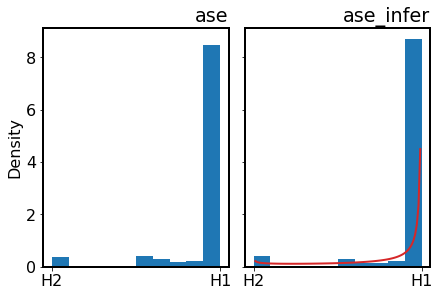

In [16]:
x = np.linspace(0, 1.0, 100)
a = ase_stat['a_hat']
b = ase_stat['b_hat']
r = stats.beta.pdf(x,a, b)

fig,ax = plt.subplots(ncols=2,sharex=True,sharey=True,constrained_layout=True)
ax[0].hist(ase['ub_H1']/(ase['ub_H2']+ase['ub_H1']).round(5),density=True)
ax[0].set_title('ase',loc='right')
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(['H2','H1'])
ax[0].set_ylabel('Density')

ax[1].hist(ase_infer['H1_infer']/(ase_infer['H2_infer']+ase_infer['H1_infer']).round(5),density=True)
ax[1].set_title('ase_infer',loc='right')
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(['H2','H1'])
ax[1].plot(x,r, lw=2, c='tab:red')

In [17]:
from lib.ase_reform_phased import *

ase_infer.columns = ['cb','gene','ub_H1','ub_H2','umi']
sparse_mat, allele_list, cb_list = process_phased(ase_infer)

cb_idx = pd.DataFrame(cb_list, columns=['cb'])
cb_idx.reset_index(inplace=True)
allele_idx = pd.DataFrame(allele_list, columns=['allele'])
allele_idx.reset_index(inplace=True)

In [18]:
from joblib import delayed,Parallel
from os import cpu_count
from lib.kpe import *

method='pb'
prefix='./example/test'

ase_mat = sparse_mat.toarray()
out_index = allele_idx['allele'].tolist()
data = Parallel(n_jobs=8)(delayed(est_vec)(vec,method) for i,vec in enumerate(ase_mat))
out_kpe_file = prefix + '_' + method + '.est'
cols = ['kon','koff','ksyn','n','mean','var']
res_df = pd.DataFrame(data,columns=cols,index=out_index)
res_df.to_csv(out_kpe_file,float_format="%.5f")
ase_out = pd.DataFrame(ase_mat, index=out_index)
out_ase_file = prefix + '.ase.reform'
ase_out.to_csv(out_ase_file)

In [19]:
display(res_df)

,kon,koff,ksyn,n,mean,var
ENSG00000196735-H1_allele,1.512842,169.999980,554.034666,5374,4.888165,25.392965
ENSG00000196735-H2_allele,0.057078,0.995009,7.569292,5374,0.416450,1.886488


In [26]:
from scipy.stats import poisson, beta, power_divergence, chi2
from lib.evaluation import *

ase_reform = ase_out
res_df.dropna(inplace=True)
n = res_df['n'].unique()

# simulate the expression with pb
cols = ['kon','koff','ksyn']
simulated_cols = [ 'sim_' + x for x in cols ]
simulated_data = Parallel(n_jobs=cpu_count())(delayed(pb_simulation)(row[cols],n) for i,row in res_df.iterrows())

# re-estimate the kp from the simulated profile
res_data = Parallel(n_jobs=cpu_count())(delayed(est_row)(row,method) for row in simulated_data)
res_df[simulated_cols] = res_data

# likelihood ratiotest
for i, (idx, row) in enumerate(res_df.iterrows()):
    sim_data = np.array(simulated_data[i])
    org_data = ase_reform.loc[idx].astype(np.float32).values

    sim_kp = row[simulated_cols].values
    org_kp = row[cols].values

    if np.sum(sim_data) == 0:
        res_df.loc[idx,'chisq_pval'] = np.nan
        res_df.loc[idx,'simlr_pval'] = np.nan
        continue

    chisq, p = GoF(sim_data, org_data)
    simlr = simLikelihoodRatioTest(sim_kp, sim_data, org_kp, org_data)

    res_df.loc[idx,'chisq_pval'] = p
    res_df.loc[idx,'simlr_pval'] = simlr

out_file = prefix + '.est.eval'
res_df.to_csv(out_file)

In [29]:
display(res_df[cols].head())
display(res_df[simulated_cols].head())

,kon,koff,ksyn
ENSG00000196735-H1_allele,1.512842,169.999980,554.034666
ENSG00000196735-H2_allele,0.057078,0.995009,7.569292


,sim_kon,sim_koff,sim_ksyn
ENSG00000196735-H1_allele,1.476585,126.175930,420.579393
ENSG00000196735-H2_allele,0.058540,0.900698,7.628224


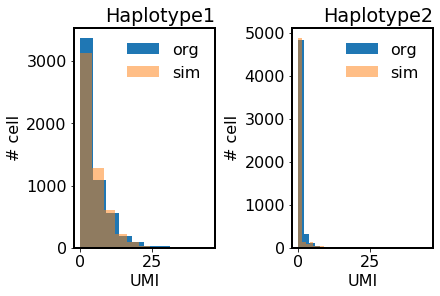

In [33]:
fig,ax = plt.subplots(ncols=2,sharex=True,constrained_layout=True)
header=['Haplotype1','Haplotype2']

for i, (idx, row) in enumerate(res_df.iterrows()):
    sim_data = np.array(simulated_data[i])
    org_data = ase_reform.loc[idx].astype(np.float32).values

    sim_kp = row[simulated_cols].values
    org_kp = row[cols].values
    ax[i].set_title(header[i],loc='right')
    ax[i].set_xlabel('UMI')
    ax[i].set_ylabel('# cell')
    ax[i].hist(org_data,label='org')
    ax[i].hist(sim_data,label='sim',alpha=0.5)
    ax[i].legend(frameon=False)

In [34]:
from lib.variance import *
# simulate the expression with pb
kpe = res_df 
out_file = prefix + '.est.var'

cols = ['kon','koff','ksyn']
data = Parallel(n_jobs=cpu_count())(\
delayed(fun)(ase_reform.loc[idx].values, row[cols].values, out_file) for idx,row in kpe.iterrows())

add_cols = ['kon_mean','koff_mean', 'ksyn_mean',\
            'kon_lower','kon_upper','koff_lower','koff_upper','ksyn_lower','ksyn_upper']

kpe[add_cols] = data

kpe.to_csv(out_file,float_format="%.5f")

In [35]:
print_cols = ['kon_mean','kon_lower','kon_upper',\
    'koff_mean','koff_lower','koff_upper',\
    'ksyn_mean','ksyn_lower','ksyn_upper']
kpe[print_cols].head()

,kon_mean,kon_lower,kon_upper,koff_mean,koff_lower,koff_upper,ksyn_mean,ksyn_lower,ksyn_upper
ENSG00000196735-H1_allele,1.516480,1.470505,1.553287,169.601634,166.188278,175.796012,553.364526,539.568937,574.382853
ENSG00000196735-H2_allele,0.056868,0.051193,0.061867,0.994267,0.904094,1.091390,7.544525,6.980317,8.134524


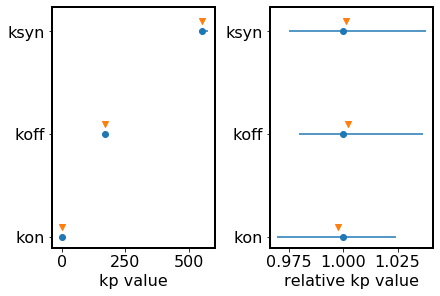

In [37]:
fig,ax = plt.subplots(constrained_layout=True, ncols=2)
allele = 'ENSG00000196735-H1_allele'

y=np.arange(len(cols))
kp_org   = ['kon','koff', 'ksyn']
kp_mean  = ['kon_mean','koff_mean', 'ksyn_mean']
kp_error = ['kon_lower','koff_lower','ksyn_lower','kon_upper','koff_upper','ksyn_upper',]

x_org = kpe.loc[allele, kp_org].values.reshape((1,-1))
x = kpe.loc[allele, kp_mean].values.reshape((1,-1))
x_error = kpe.loc[allele, kp_error].values.reshape((2, -1))
x_error_reform = abs(x_error - x)

ax[0].errorbar(x.reshape(-1), y, xerr=x_error_reform,fmt='o')
ax[0].scatter(x_org.reshape(-1), y+0.1, marker='v', color='#ff7f0e')
ax[0].set_xlabel('kp value')
ax[0].set_yticks(y)
ax[0].set_yticklabels(['kon','koff','ksyn'])

ax[1].errorbar(np.ones(len(cols)), y, xerr=x_error_reform/x,fmt='o')
ax[1].scatter(x_org/x, y+0.1, marker='v', color='#ff7f0e')
ax[1].set_xlabel('relative kp value')
ax[1].set_yticks(y)
ax[1].set_yticklabels(['kon','koff','ksyn'])

plt.show()


In [42]:
ase_profile='./example/test.ase.record'
ase_eval = pd.read_csv(ase_profile, header=0)
ase_eval['a_qc'] = ase_eval.apply(lambda x: (x.Ia_lb > 0) & (x.Ia_ub > 0) ,axis=1)
ase_eval['b_qc'] = ase_eval.apply(lambda x: (x.Ib_lb > 0) & (x.Ib_ub > 0),axis=1)
ase_eval['qc']   = ase_eval.apply(lambda x: x.a_qc & x.b_qc,axis=1)
display(ase_eval)

,gene,nref,nall,percent,a_hat,Ia_lb,Ia_ub,b_hat,Ib_lb,Ib_ub,a_qc,b_qc,qc
0,ENSG00000196735,3309,5374,0.615742,0.722689,0.618249,0.82713,0.062451,0.054068,0.070835,True,True,True


In [43]:
kpe[['gene','allele']] = kpe.index.to_series().str.split('-', n=1, expand=True)
filter_gene = ase_eval.loc[ase_eval['qc']==True,'gene']
kpe_filter = kpe.loc[kpe['gene'].isin(filter_gene)]
display(kpe_filter)

,kon,koff,ksyn,n,mean,var,sim_kon,sim_koff,sim_ksyn,chisq_pval,...,koff_mean,ksyn_mean,kon_lower,kon_upper,koff_lower,koff_upper,ksyn_lower,ksyn_upper,gene,allele
ENSG00000196735-H1_allele,1.512842,169.999980,554.034666,5374,4.888165,25.392965,1.476585,126.175930,420.579393,0.970115,...,169.601634,553.364526,1.470505,1.553287,166.188278,175.796012,539.568937,574.382853,ENSG00000196735,H1_allele
ENSG00000196735-H2_allele,0.057078,0.995009,7.569292,5374,0.416450,1.886488,0.058540,0.900698,7.628224,0.750283,...,0.994267,7.544525,0.051193,0.061867,0.904094,1.091390,6.980317,8.134524,ENSG00000196735,H2_allele
